In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna

from category_encoders.target_encoder import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import gpboost as gpb

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Set print options
np.set_printoptions(suppress=True, precision=4, edgeitems = 7)
pd.options.display.float_format = '{:.4f}'.format
pd.set_option('display.max_columns', None)

# Preprocessing

In [3]:
random_state = 1923

In [4]:
# Read data
df = pd.read_csv("./InputData/full_data.csv")

In [5]:
# Reindex data from 0:N
df = df.reset_index(drop = True)

In [6]:
# Drop rows with too high duration
high_end = 10800 # 3 hours
df = df[df["duration"] <= high_end]

In [7]:
# Get rid of rank-deficiency by dropping highly correlated columns
# The below setting gets rid of the rank deficiency error & yields the best testing performance
df = df.drop(
    [
    "num_distinct_items", 
    "total_outstanding_orders", 
    "total_busy_dashers", 
    #"total_onshift_dashers",
    #"total_available_dashers"
], axis = 1)

In [8]:
df["intercept"] = 1

In [9]:
# Split features & target, drop non-feature columns
X = df.drop(["created_at", "actual_delivery_time", "duration"], axis = 1)
y = df.duration

In [10]:
# Split features, GP variables
GP = X[["hour_sin", "hour_cos", "minute_sin", "minute_cos"]]
X = X.drop(["hour_sin", "hour_cos", "minute_sin", "minute_cos"], axis = 1)

In [11]:
train_end = int(len(df) * 0.6)

In [12]:
val_end = train_end + int(len(df) * 0.2)

In [13]:
# Create target encoders

# store_id encoder with hierarchy, top level market_id
hierarchy = pd.DataFrame(X["market_id"]).rename({"market_id": "HIER_store_id_1"}, axis = 1)
encoder_storeid = TargetEncoder(cols = ["store_id"], hierarchy = hierarchy)

# Encoder for remaining categoricals, without hierarchy
encoder = TargetEncoder(cols = ["market_id", "store_primary_category", "order_protocol"])

pipeline = Pipeline([
    ("encoder_storeid", encoder_storeid),
    ("encoder", encoder)
])

# Testing & diagnostics

In [14]:
# Combine train & validation data
X_train, X_test = X[:val_end], X[val_end:]
GP_train, GP_test = GP[:val_end], GP[val_end:]
y_train, y_test = y[:val_end], y[val_end:]

In [15]:
# Preprocess data
X_train = pipeline.fit_transform(X_train, y_train)
X_test = pipeline.transform(X_test)

In [16]:
# Create gpb data
train = gpb.Dataset(X_train, y_train)
test = gpb.Dataset(X_test, y_test)

In [17]:
# Create random effects model
model = gpb.GPModel(
        gp_coords = GP_train,
        likelihood = "gaussian",
        gp_approx = "vecchia",
        seed = random_state
    )

[GPBoost] [Info] Starting nearest neighbor search for Vecchia approximation
[GPBoost] [Info] Nearest neighbors for Vecchia approximation found


Other settings not feasible due to memory limitations.

In [18]:
# Train mixed effects model
model.fit(X = X_train, y = y_train, params = {"std_dev": True})

In [19]:
# Make predictions on test data
preds = model.predict(X_pred = X_test, gp_coords_pred = GP_test, predict_var = True)

[GPBoost] [Warning] Calculation of (only) predictive variances is currently not optimized for the Vecchia approximation, and this might takes a lot of time and/or memory.


In [20]:
preds

{'mu': array([4145.155 , 3259.504 , 3748.2159, 3357.1177, 4307.7323, 3143.9645,
        2458.2622, ..., 1975.902 , 2462.7382, 1072.8504, 1976.2559,
        2738.473 , 3112.1808, 2531.1467]),
 'cov': None,
 'var': array([689107.2248, 689107.2248, 689107.2248, 689107.2248, 689107.2248,
        689107.2248, 689107.2248, ..., 689134.027 , 689134.027 ,
        689199.0621, 689199.0621, 689162.6029, 689162.6029, 689183.5296])}

In [21]:
# Combine back with test data
df_pred = X_test.copy()
df_pred["preds"] = preds["mu"]
df_pred["sd"] = np.sqrt(preds["var"])
df_pred["actual"] = y_test
df_pred["residual"] = y_test - df_pred["preds"]

In [22]:
# Calculate RMSE, MAPE
print("RMSE:")
print(mean_squared_error(df_pred["actual"], df_pred["preds"], squared = False))

print("MAPE:")
print(mean_absolute_percentage_error(df_pred["actual"], df_pred["preds"]))

RMSE:
941.6878479896117
MAPE:
0.23885733351932814


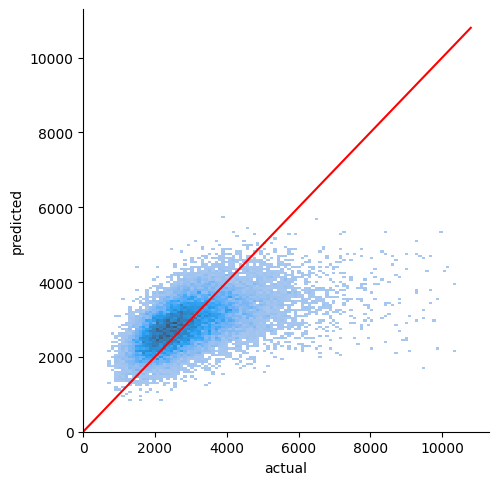

In [23]:
# Plot predicted vs. actual
_ = sns.displot(x = df_pred["actual"],  y = df_pred["preds"])
_ = plt.plot([0, high_end], [0, high_end], c = "red")
_ = plt.xlim(0, high_end + 500)
_ = plt.ylim(0, high_end + 500)
_ = plt.xlabel("actual")
_ = plt.ylabel("predicted")

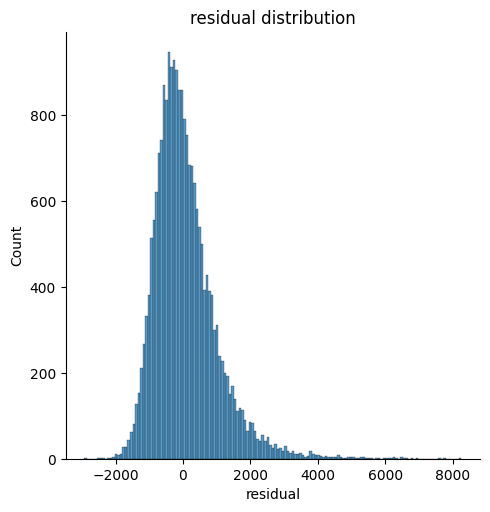

In [24]:
# Residual distribution
_ = sns.displot(df_pred["residual"])
_ = plt.title("residual distribution")

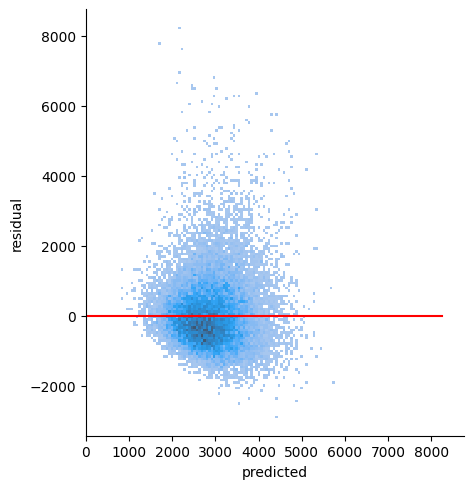

In [25]:
# Predicted vs residual
low_end = min(df_pred.residual)
max_resids = max(df_pred.residual)
_ = sns.displot(data = df_pred, x = "preds", y= "residual")
_ = plt.plot([0, max_resids], [0, 0], c = "red")
_ = plt.xlim(0, max_resids + 500)
_ = plt.ylim(low_end - 500, max_resids + 500)
_ = plt.xlabel("predicted")
_ = plt.ylabel("residual")

In [26]:
model.summary()

Model summary:
     Log-lik          AIC          BIC
-719577.1500 1439206.3000 1439450.4100
Nb. observations: 88345
-----------------------------------------------------
Covariance parameters (random effects):
                Param.  Std. dev.
Error_term 677258.5119  3243.1275
GP_var      39469.9813  1668.1424
GP_range        0.6588     0.9475
-----------------------------------------------------
Linear regression coefficients (fixed effects):
                                                 Param.  Std. dev.  z value  \
market_id                                        0.1164     0.0427   2.7277   
store_id                                         0.9474     0.0096  99.0489   
store_primary_category                          -0.1744     0.0209  -8.3557   
order_protocol                                   0.0865     0.0506   1.7090   
total_items                                     16.3490     2.2828   7.1617   
subtotal                                         0.0684     0.0030  22.4810  

# Inference

In [27]:
# Get model parameters for SHAP
coefs = model.get_coef().iloc[:-1, :-1].values.flatten()
intercept = model.get_coef().iloc[:-1, -1].values

In [28]:
# Get data parameters for SHAP
X_train_no_intercept = X_train.drop("intercept", axis = 1)
means = X_train_no_intercept.mean().values
covs = X_train_no_intercept.cov().values

In [29]:
explainer = shap.LinearExplainer(
    (coefs, intercept), 
    (means, covs)
)
explainer.expected_value = explainer.expected_value[0] # To fix slicing issue with some SHAP plots
shap_values = explainer(X_train_no_intercept)

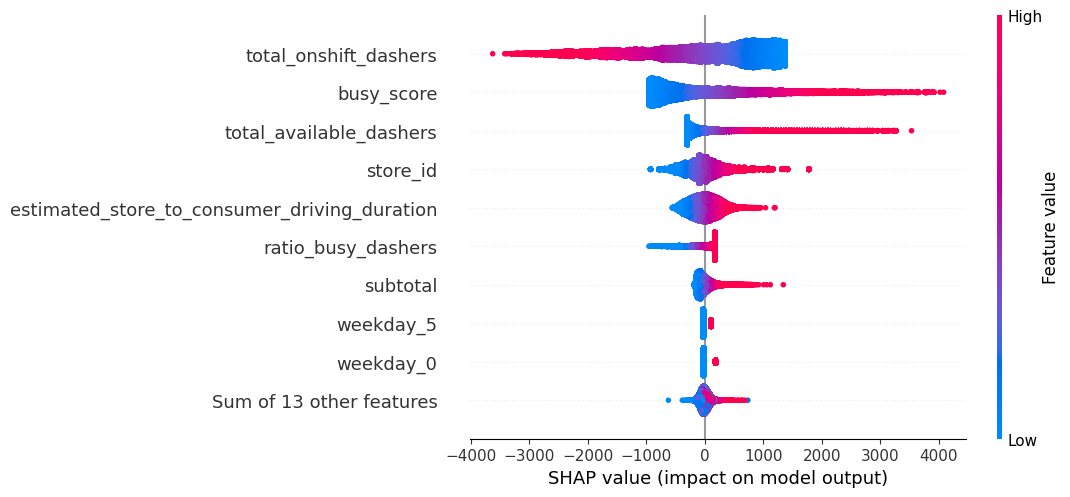

In [30]:
# SHAP summary of all features
shap.plots.beeswarm(shap_values)

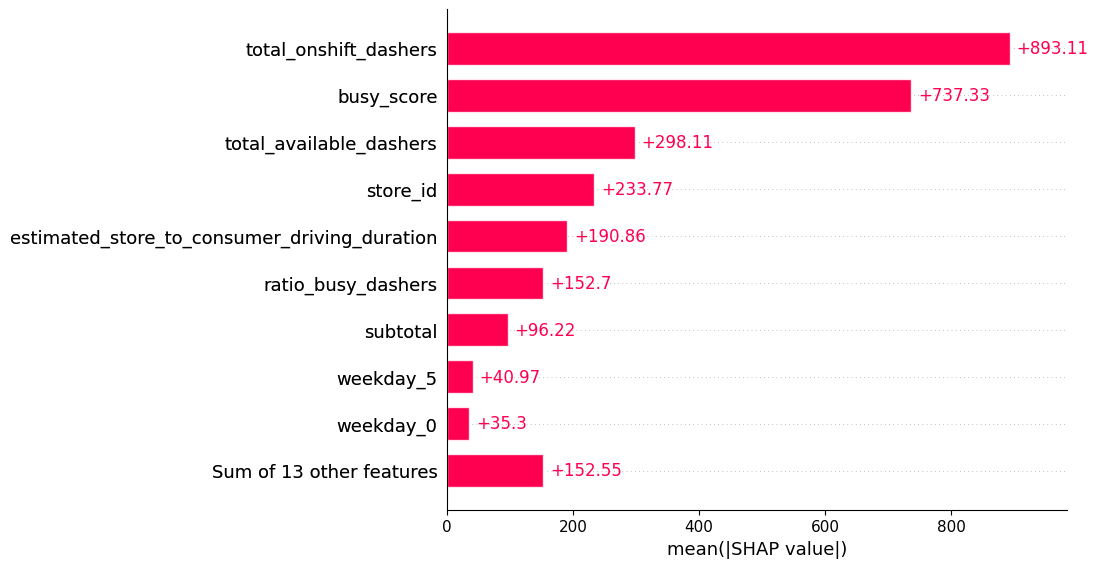

In [31]:
shap.plots.bar(shap_values)

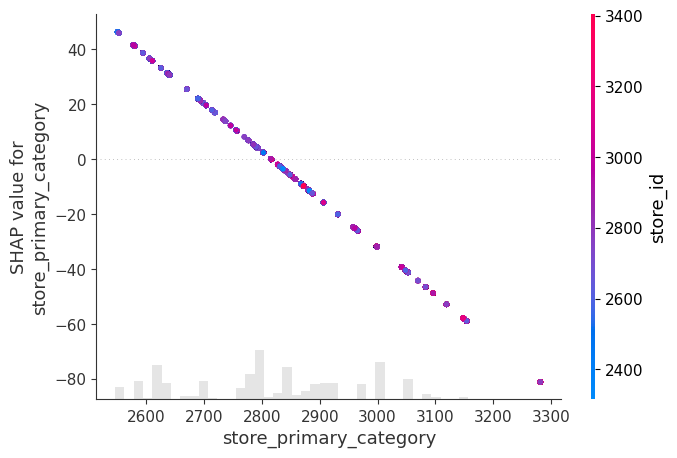

In [32]:
# Direction of store_primary_category's effect on predictions
shap.plots.scatter(shap_values[:, "store_primary_category"], color = shap_values[:, "store_id"])

# Findings

- Performance bit better than fixed effects LM, worse than grouped effects LM.
- The coefficient of store_primary_category again reversed to the (seemingly) wrong direction, just like the fixed effects LM. Likely because group variation is not accounted for.